## Fitting Min 7-Day Average Flow Data from Russian River Basins to a Pearson-III Distribution Using the Method of Moments to Quantify Extremeness of Years
by Arman Omidvar

Analysis of Low Flows and Selected Methods for Estimating Low-Flow Characteristics at Partial-Record and Ungaged Stream Sites in Western Washington

In [49]:
import numpy as np
import pandas as pd
from scipy.stats import pearson3
import matplotlib.pyplot as plt
from scipy.special import gammaln

In [50]:
def sample_mean(low_flows):
    log_low_flows = np.log10(low_flows)
    return np.mean(log_low_flows)

def sample_std(low_flows):
    log_low_flows = np.log10(low_flows)
    return np.std(log_low_flows, ddof=1)

def sample_skew(low_flows):
    n = len(low_flows)
    log_low_flows = np.log10(low_flows)
    std = np.std(log_low_flows, ddof=1)
    mean = np.mean(log_low_flows)

    return (np.sum((log_low_flows - mean) ** 3) * n) / ((n - 1) * (n - 2) * (std ** 3))

In [51]:
def pearsonIII_alpha_estimate(sample_skew):
    """
    Compute the MOM estimate of the alpha parameter for a Pearson-III distribution based on the weighted skew.
    """
    alpha = (4 / (sample_skew ** 2))
    return alpha

def pearsonIII_beta_estimate(sample_skew, standard_error, alpha_hat):
    """
    Compute the MOM estimate of the beta parameter for a Pearson-III distribution.
    """
    beta_hat = np.sign(sample_skew) * (standard_error ** 2 / alpha_hat) ** 0.5
    return beta_hat

def pearsonIII_tau_estimate(mean_log_peak_flows, beta_hat, alpha_hat):
    """
    Compute the MOM estimate of the tau parameter for a Pearson-III distribution.
    """
    tau_hat = mean_log_peak_flows - (alpha_hat * beta_hat)
    return tau_hat

Basin: Calpella
alpha_hat: 2.8625429073921698, beta_hat: -0.28210717613536923, tau_hat: 2.397013431211164


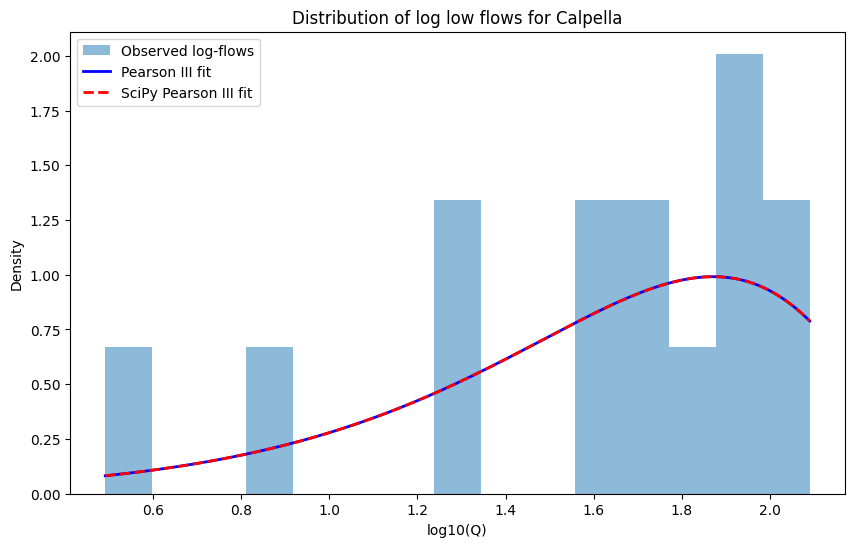

C:\Users\arman\AppData\Local\Temp\ipykernel_3852\1870406960.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data[basin]['Date'] = pd.to_datetime(all_data[basin]['Date'])


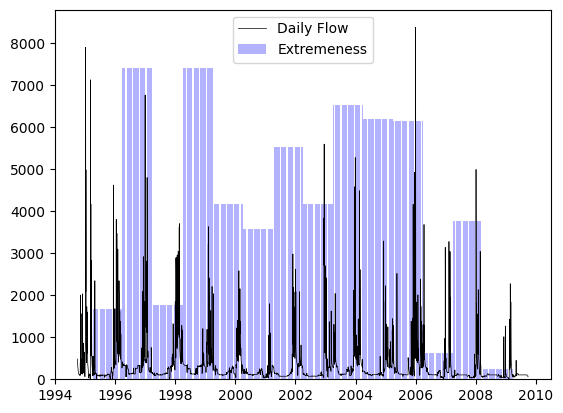

<Figure size 30000x10000 with 0 Axes>

Basin: Guerneville
alpha_hat: 12.469999231131977, beta_hat: -0.025586619865968205, tau_hat: 2.7101475271546756


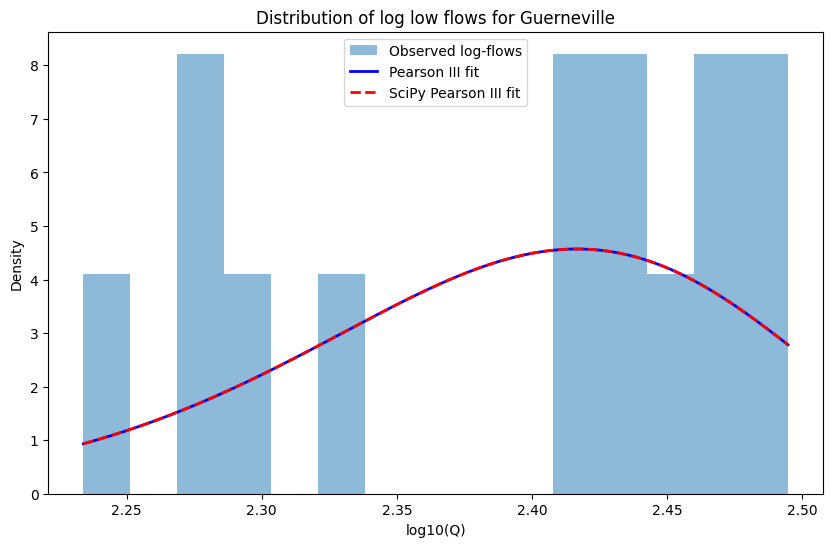

C:\Users\arman\AppData\Local\Temp\ipykernel_3852\1870406960.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data[basin]['Date'] = pd.to_datetime(all_data[basin]['Date'])


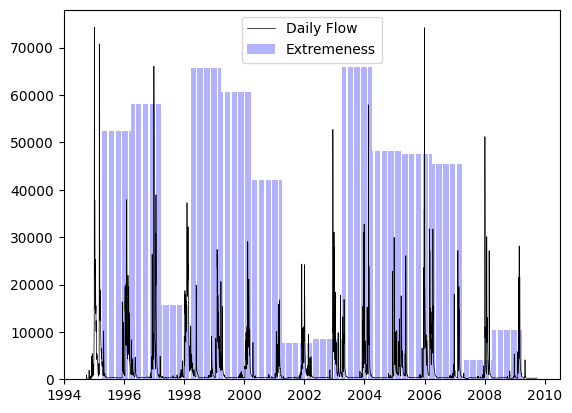

<Figure size 30000x10000 with 0 Axes>

Basin: Hopland
alpha_hat: 21.857209010875355, beta_hat: -0.03531381124010539, tau_hat: 2.87238949116655


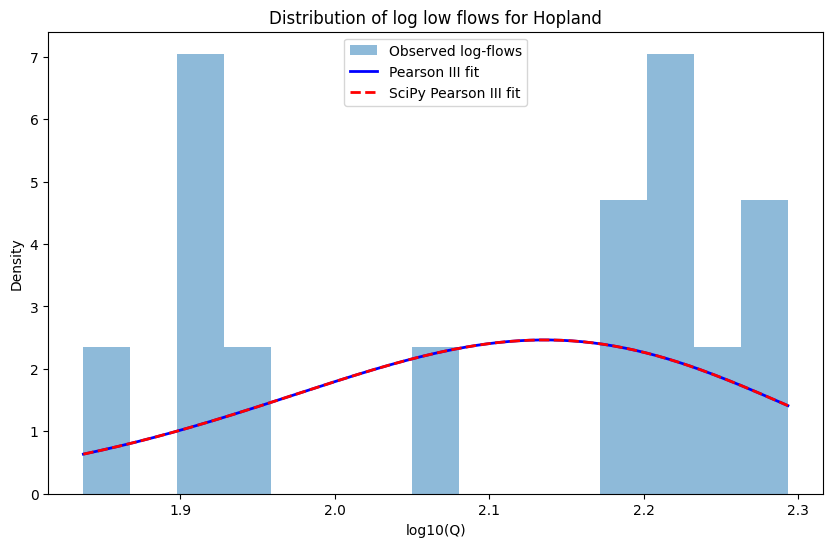

C:\Users\arman\AppData\Local\Temp\ipykernel_3852\1870406960.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data[basin]['Date'] = pd.to_datetime(all_data[basin]['Date'])


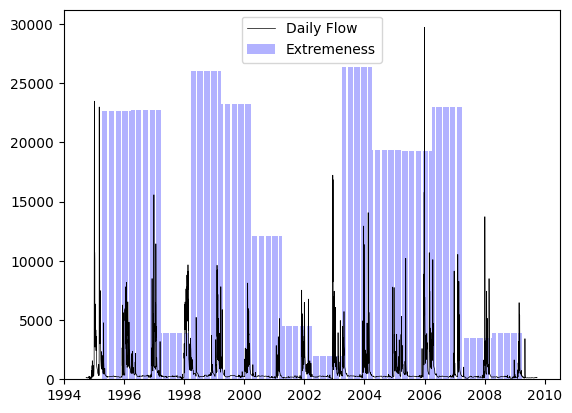

<Figure size 30000x10000 with 0 Axes>

Basin: Warm Springs
alpha_hat: 75.61780339145264, beta_hat: -0.009288139332316316, tau_hat: 2.466538666197588


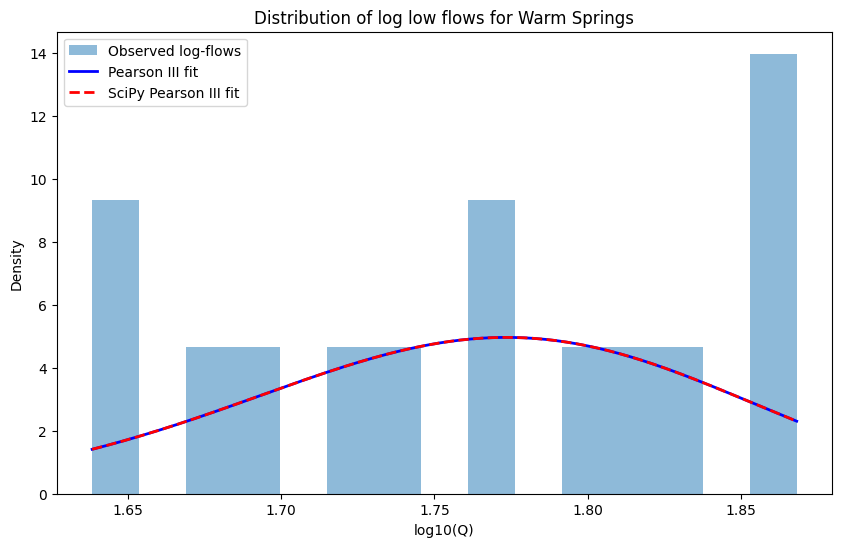

C:\Users\arman\AppData\Local\Temp\ipykernel_3852\1870406960.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data[basin]['Date'] = pd.to_datetime(all_data[basin]['Date'])


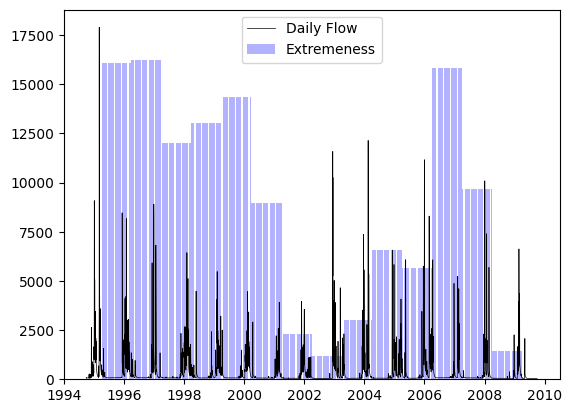

<Figure size 30000x10000 with 0 Axes>

In [52]:
calpella_low_flows = pd.read_csv('russian_river_low_flows(7d-avg)/Calpella.csv')[1:][:-1]
guerneville_low_flows = pd.read_csv('russian_river_low_flows(7d-avg)/Guerneville.csv')[1:][:-1]
hopland_low_flows = pd.read_csv('russian_river_low_flows(7d-avg)/Hopland.csv')[1:][:-1]
warmsprings_low_flows = pd.read_csv('russian_river_low_flows(7d-avg)/Warm.csv')[1:][:-1]

calpella_all_data = pd.read_csv('russian_river_data/Calpella_daily.csv')
guerneville_all_data = pd.read_csv('russian_river_data/Guerneville_daily.csv')
hopland_all_data = pd.read_csv('russian_river_data/Hopland_daily.csv')
warmsprings_all_data = pd.read_csv('russian_river_data/WarmSprings_Inflow_daily.csv')


low_flows = {'Calpella': calpella_low_flows['mav'].values,
              'Guerneville': guerneville_low_flows['mav'].values,
              'Hopland': hopland_low_flows['mav'].values,
              'Warm Springs': warmsprings_low_flows['mav'].values}

all_data = {'Calpella': calpella_all_data,
            'Guerneville': guerneville_all_data,
            'Hopland': hopland_all_data,
            'Warm Springs': warmsprings_all_data}


extreme_years = pd.DataFrame()
extreme_years['climatic_year'] = calpella_low_flows['climatic_year']


def pearson3_pdf(x, alpha, beta, tau):
    x = np.asarray(x, dtype=float)

    if alpha <= 0 or beta == 0:
        return np.full_like(x, np.nan)

    z = (x - tau) / beta
    mask = z > 0

    out = np.zeros_like(x, dtype=float)
    logpdf = -np.log(abs(beta)) - gammaln(alpha) + (alpha - 1)*np.log(z[mask]) - z[mask]
    out[mask] = np.exp(logpdf)
    return out

for basin in low_flows.keys():
    basin_low_flows = low_flows[basin]
    sam_skew = sample_skew(basin_low_flows)

    log_flows = np.log10(basin_low_flows)
    mean_log_flows = np.mean(log_flows)
    std_log_flows = np.std(log_flows, ddof=1)

    alpha_hat = pearsonIII_alpha_estimate(sam_skew)
    beta_hat = pearsonIII_beta_estimate(sam_skew, std_log_flows, alpha_hat)
    tau_hat = pearsonIII_tau_estimate(mean_log_flows, beta_hat, alpha_hat)

    print(f'Basin: {basin}')
    print(f'alpha_hat: {alpha_hat}, beta_hat: {beta_hat}, tau_hat: {tau_hat}')

    dist = pearson3(sam_skew, loc=mean_log_flows, scale=std_log_flows)
    x = np.linspace(min(log_flows), max(log_flows), 200)
    scipy_pdf_vals = dist.pdf(x)
    my_pdf_vals = pearson3_pdf(x, alpha_hat, beta_hat, tau_hat)

    extreme_years[basin] = 1 - dist.cdf(np.log10(basin_low_flows))

    plt.figure(figsize=(10, 6))
    plt.hist(log_flows, bins=15, density=True, alpha=0.5, label='Observed log-flows')
    plt.plot(x, my_pdf_vals, 'b-', lw=2, label='Pearson III fit')
    plt.plot(x, scipy_pdf_vals, 'r--', lw=2, label='SciPy Pearson III fit')
    plt.xlabel('log10(Q)')
    plt.ylabel('Density')
    plt.title(f'Distribution of log low flows for {basin}')
    plt.legend()
    plt.show()

    all_data[basin]['Date'] = pd.to_datetime(all_data[basin]['Date'])
    flows = all_data[basin].copy()
    flows['climatic_year'] = np.where(flows['Date'].dt.month >= 4, flows['Date'].dt.year + 1, flows['Date'].dt.year)
    flows['mav'] = None
    flows['extremeness'] = None
    for i, year in enumerate(flows['climatic_year'].unique()[1:][:-1]):
        flows.loc[flows['climatic_year'] == year, 'mav'] = basin_low_flows[i]
        flows.loc[flows['climatic_year'] == year, 'extremeness'] = 1 - extreme_years[basin].iloc[i]


    plt.bar(
        flows['Date'],
        flows['extremeness'] * max(all_data[basin].iloc[:, 3]),
        color="blue",
        alpha=0.3,
        label="Extremeness"
    )

    # plt.plot(
    #     peak_flow_df['Date'],
    #     peak_flow_df['peak_flow'],
    #     color="blue",
    #     marker="_",
    #     linestyle='',
    #     label="Yearly Peak Flow"
    # )

    plt.plot(
        all_data[basin]['Date'],
        all_data[basin].iloc[:, 3],
        color="black",
        linewidth=0.5,
        label="Daily Flow",
    )

    plt.legend()
    plt.figure(figsize=(300, 100))
    plt.show()

In [53]:
extreme_years.to_csv('low_flow_analysis.csv', index=False)
print(extreme_years)

    climatic_year  Calpella  Guerneville   Hopland  Warm Springs
1            1996  0.800025     0.294236  0.239178      0.101292
2            1997  0.114495     0.219353  0.233826      0.093610
3            1998  0.788850     0.787765  0.869280      0.329920
4            1999  0.116445     0.115862  0.123828      0.271576
5            2000  0.503348     0.184684  0.217615      0.198626
6            2001  0.572977     0.432491  0.591759      0.499357
7            2002  0.341498     0.895704  0.847497      0.870173
8            2003  0.501321     0.885445  0.934734      0.934743
9            2004  0.220862     0.114139  0.113367      0.832023
10           2005  0.260482     0.352425  0.348353      0.633832
11           2006  0.267317     0.358955  0.352721      0.684272
12           2007  0.925160     0.388118  0.225406      0.115278
13           2008  0.551494     0.945875  0.881681      0.458583
14           2009  0.969722     0.860985  0.868623      0.920772


In [54]:
basins = [col for col in extreme_years.columns if col != "climatic_year"]

for basin in basins:
    print(f"\n=== {basin} (lowest → highest extremeness) ===")
    
    ranked = (
        extreme_years[["climatic_year", basin]]
        .sort_values(by=basin, ascending=True)  # lowest = most extreme
        .reset_index(drop=True)
    )
    
    ranked["rank"] = ranked.index + 1
    
    print(ranked[["rank", "climatic_year", basin]])


=== Calpella (lowest → highest extremeness) ===
    rank  climatic_year  Calpella
0      1           1997  0.114495
1      2           1999  0.116445
2      3           2004  0.220862
3      4           2005  0.260482
4      5           2006  0.267317
5      6           2002  0.341498
6      7           2003  0.501321
7      8           2000  0.503348
8      9           2008  0.551494
9     10           2001  0.572977
10    11           1998  0.788850
11    12           1996  0.800025
12    13           2007  0.925160
13    14           2009  0.969722

=== Guerneville (lowest → highest extremeness) ===
    rank  climatic_year  Guerneville
0      1           2004     0.114139
1      2           1999     0.115862
2      3           2000     0.184684
3      4           1997     0.219353
4      5           1996     0.294236
5      6           2005     0.352425
6      7           2006     0.358955
7      8           2007     0.388118
8      9           2001     0.432491
9     10           